In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import hugegp as gp

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

rng = jr.key(13)

In [2]:
original_points = jnp.mgrid[0:3:500j, 0:3:500j].reshape(2, -1).T
offsets = gp.make_offsets(len(original_points), 1000, 1.3, 5000)
points, neighbors, indices = gp.build_jax_graph(original_points, offsets=offsets, k=20, cuda=True)
unindices = jnp.argsort(indices)

In [3]:
rng, key = jr.split(rng)
xi = jr.normal(key, shape=(10,len(points)))
values = jax.vmap(Partial(gp.generate, points, neighbors, offsets, gp.matern_cov))(xi)
original_values = values[:,unindices]

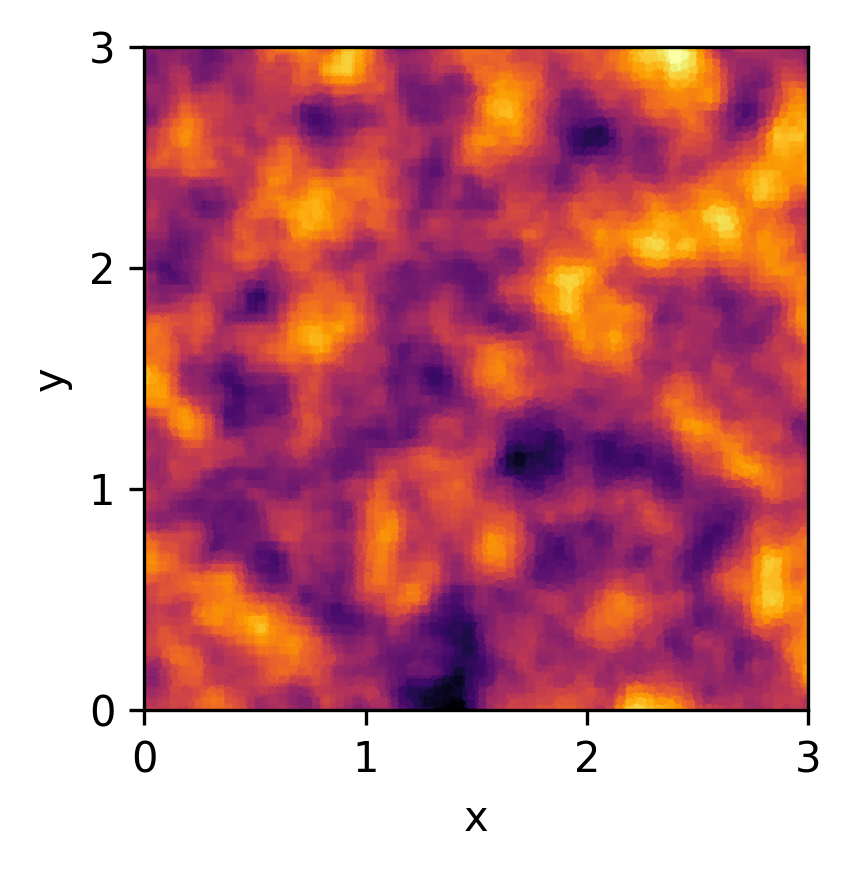

In [7]:
fig = plt.figure(figsize=(3,3), dpi=300)
s = plt.scatter(*points[:30].T, c=values[1][:30], cmap='inferno', s=1, vmin=-3, vmax=3)
plt.gca().set(aspect='equal', xlim=(0,3), ylim=(0,3), yticks=[0,1,2,3], xlabel='x', ylabel='y')
# plt.scatter([1.3, 1.6], [1.5, 1.7], c='white', marker='x')

def update(i):
    s.set_offsets(points[:i])
    s.set_array(values[1][:i].ravel())
    return [s]

ani = FuncAnimation(plt.gcf(), update, frames=[32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536], interval=500, blit=True)
fig.tight_layout()
HTML(ani.to_html5_video())

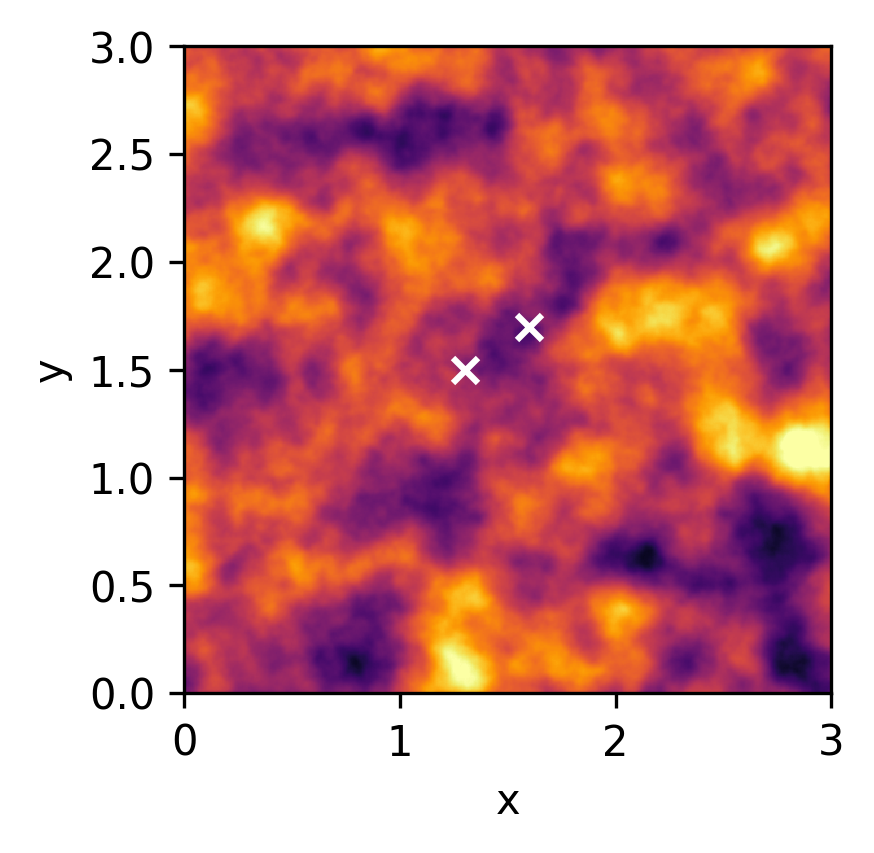

In [54]:
fig = plt.figure(figsize=(3,3), dpi=300)
mesh = plt.pcolormesh(original_points[:,0].reshape(500,500), original_points[:,1].reshape(500,500), original_values[0].reshape(500,500), cmap='inferno', vmin=-3, vmax=3)
plt.gca().set(aspect='equal', xlim=(0,3), ylim=(0,3), xlabel='x', ylabel='y')
plt.scatter([1.3, 1.6], [1.5, 1.7], c='white', marker='x')

def update(i):
    mesh.set_array(original_values[i].reshape(500,500).ravel())
    return [mesh]

ani = FuncAnimation(plt.gcf(), update, frames=10, interval=500, blit=True)
fig.tight_layout()
HTML(ani.to_html5_video())

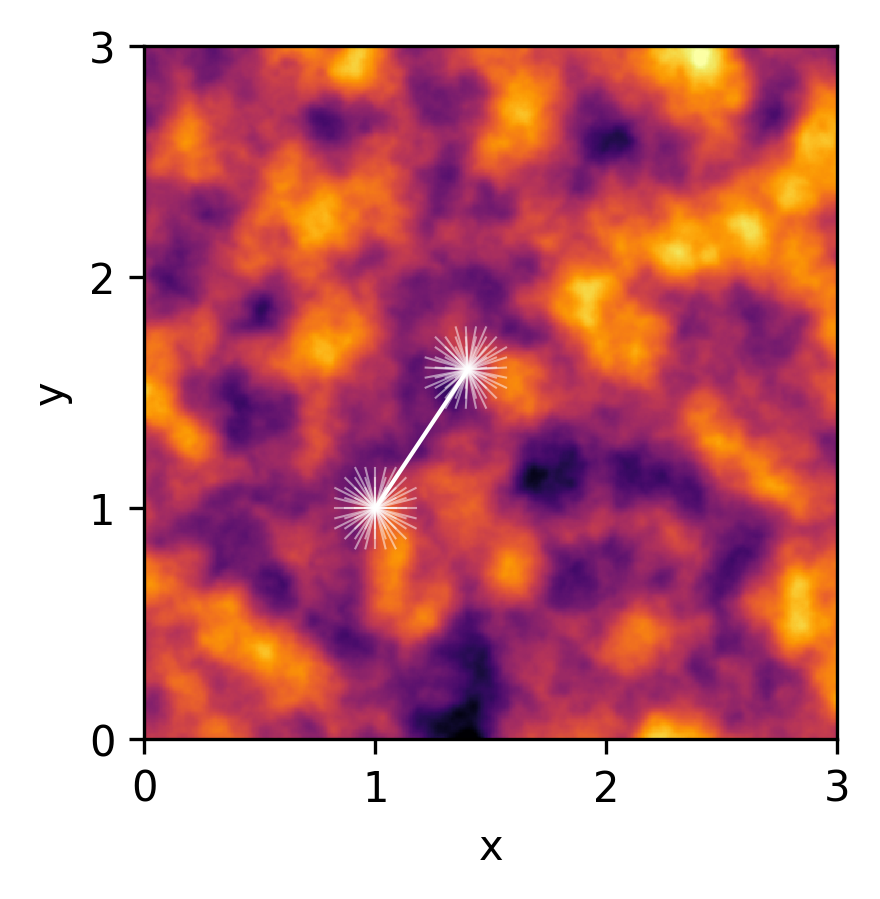

In [17]:
plt.figure(figsize=(3,3), dpi=300)
plt.pcolormesh(original_points[:,0].reshape(500,500), original_points[:,1].reshape(500,500), original_values[1].reshape(500,500), cmap='inferno', vmin=-3, vmax=3)
plt.gca().set(aspect='equal', xlim=(0,3), ylim=(0,3), yticks=[0,1,2,3], xlabel='x', ylabel='y')


origin = jnp.mgrid[0:3:70j, 0:3:70j].reshape(2, -1)
destination = jnp.zeros_like(origin) + jnp.array([[1.0],[1.0]])
in_range = jnp.linalg.norm(origin - destination, axis=0) < 0.2
origin = origin[:, in_range]
destination = destination[:, in_range]
for i in range(origin.shape[1]):
    plt.plot([origin[0,i], destination[0,i]], [origin[1,i], destination[1,i]], c='white', lw=0.5, alpha=0.5)

origin = jnp.mgrid[0:3:70j, 0:3:70j].reshape(2, -1)
destination2 = jnp.zeros_like(origin) + jnp.array([[1.4],[1.6]])
in_range = jnp.linalg.norm(origin - destination2, axis=0) < 0.2
origin = origin[:, in_range]
destination2 = destination2[:, in_range]
for i in range(origin.shape[1]):
    plt.plot([origin[0,i], destination2[0,i]], [origin[1,i], destination2[1,i]], c='white', lw=0.5, alpha=0.5)

plt.plot([destination[0,0], destination2[0,0]], [destination[1,0], destination2[1,0]], c='white', lw=1)

# plt.scatter([1., 1.6], [1.5, 1.7], c='white', marker='x')
plt.show()

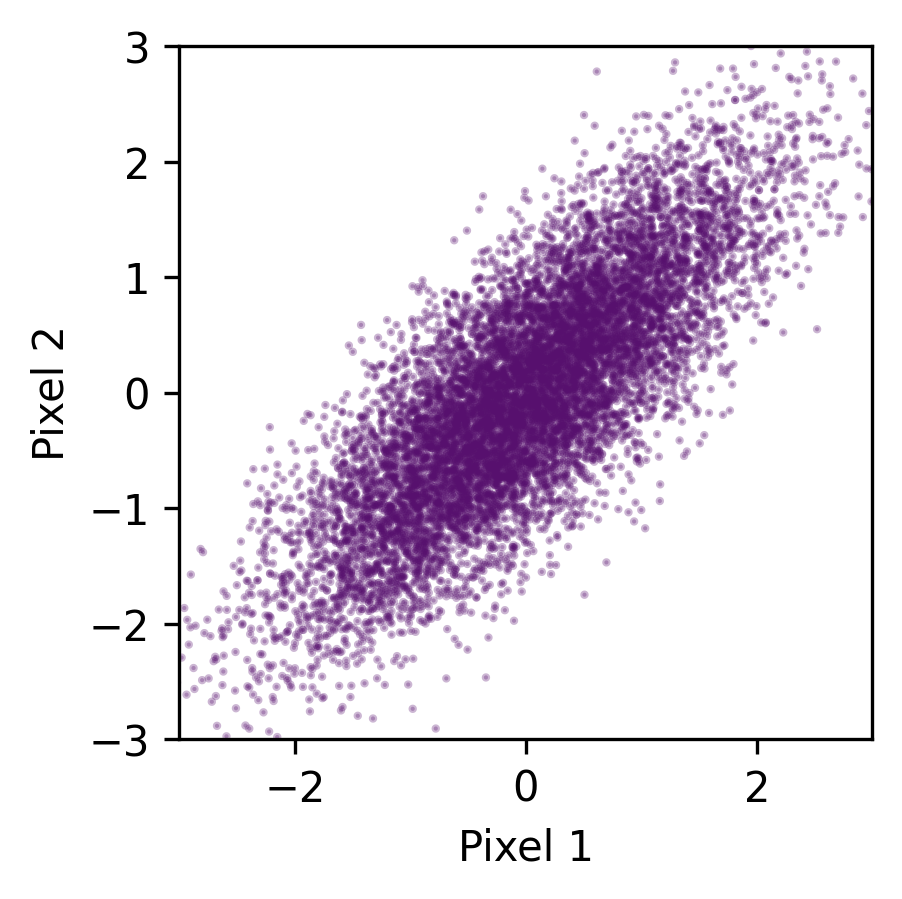

In [29]:
key, rng = jr.split(rng)
xi = jr.normal(key, shape=(2, 10_000))

K = jnp.array([[1.0, 0.8], [0.8, 1.0]])
L = jnp.linalg.cholesky(K)
values = L @ xi

plt.figure(figsize=(3,3), dpi=300)
plt.scatter(*values, s=1, alpha=0.3, cmap='inferno', c=jnp.zeros(len(values[0])), vmin=-1, vmax=3)
plt.gca().set(aspect='equal', xlim=(-3,3), ylim=(-3,3), xlabel='Pixel 1', ylabel='Pixel 2')
plt.show()

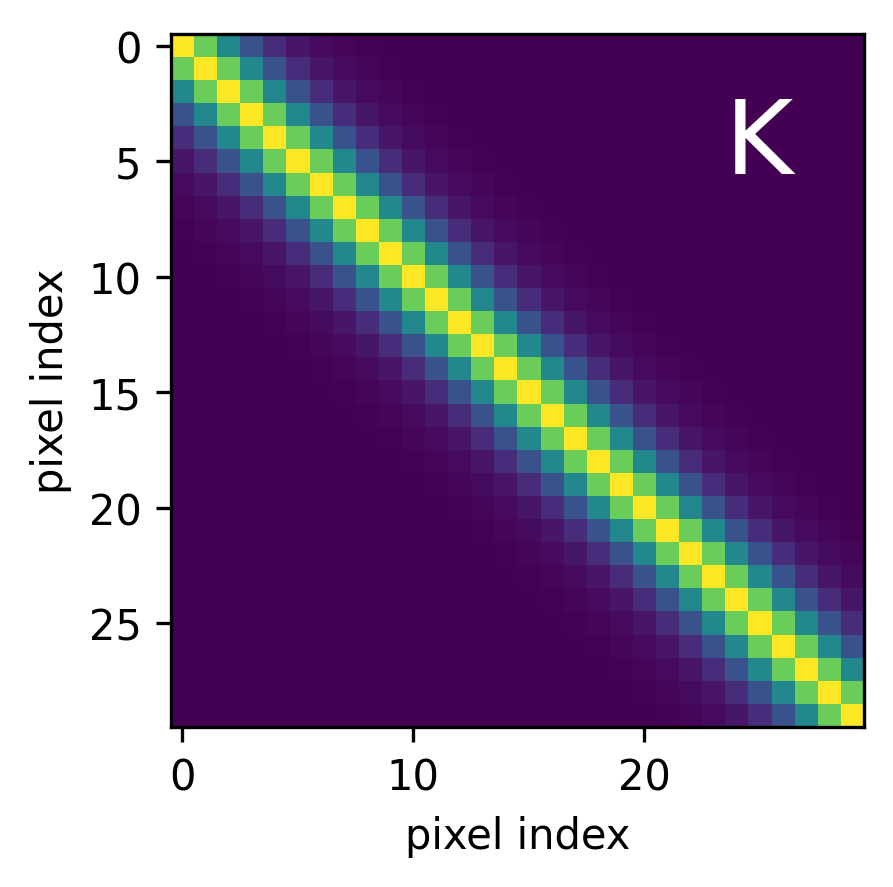

In [115]:
r = jnp.linspace(0, 3, 30)[:,None]
K = gp.compute_cov_matrix(gp.matern_cov, r, r)
# K = K.at[K<0.05].set(jnp.nan)

plt.figure(figsize=(3,3), dpi=300)
plt.imshow(K)
plt.text(0.8, 0.8, "K", color='white', transform=plt.gca().transAxes, fontsize=25)
plt.gca().set(xlabel='pixel index', ylabel='pixel index')
plt.show()

In [6]:
rng, key = jr.split(rng)
points = jr.normal(key, shape=(5_000, 2))
offsets = gp.make_offsets(len(points), 1000, 1.3)
points, neighbors, indices = gp.build_jax_graph(points, offsets=offsets, k=10, cuda=True)

In [7]:
rng, key = jr.split(rng)
xi = jr.normal(key, shape=(5_000,))

values = gp.generate(points, neighbors, offsets, gp.matern_cov, xi)

In [8]:
K = gp.compute_cov_matrix(gp.matern_cov, points, points)
L = jnp.linalg.cholesky(K)
values_true = L @ xi

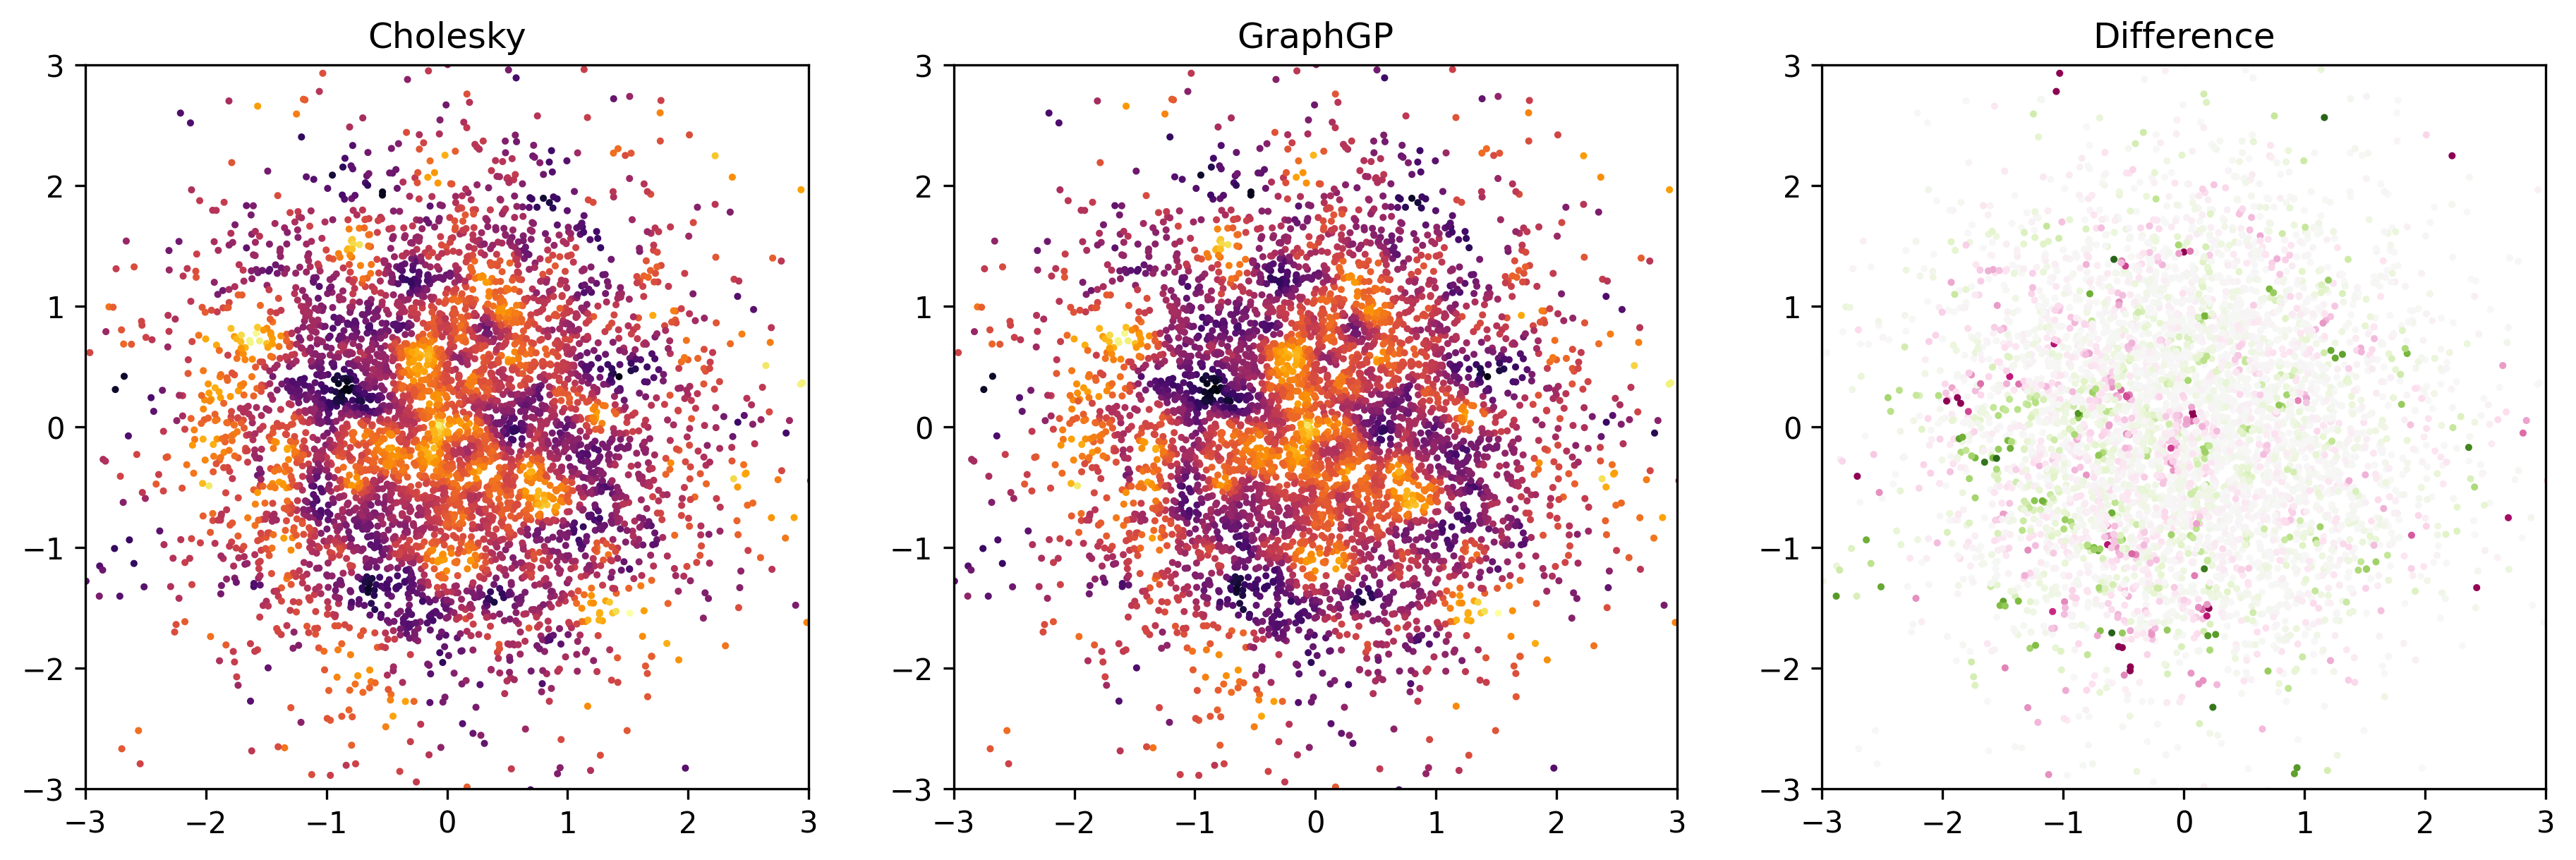

In [9]:
fig, axes = plt.subplots(figsize=(15,5), ncols=3, dpi=300)
axes[1].scatter(*points.T, c=values, cmap='inferno', s=2)
axes[0].scatter(*points.T, c=values_true, cmap='inferno', s=2)
axes[2].scatter(*points.T, c=values - values_true, cmap='PiYG', vmin=-0.5, vmax=0.5, s=2)
for i, ax in enumerate(axes):
    ax.set(aspect='equal', xlim=(-3,3), ylim=(-3,3), title=["Cholesky", "GraphGP", "Difference"][i])
plt.show()

In [40]:
def log_spiral_points(noise, a=1, k=0.2, width=0.5, theta_max=16 * jnp.pi):
    theta = jnp.linspace(0, theta_max, len(noise))
    noise_theta = theta + width * noise
    r = a * jnp.exp(k * theta) / jnp.exp(k * theta_max)
    points = r * jnp.stack([jnp.cos(noise_theta), jnp.sin(noise_theta)])
    return points.T

In [49]:
n_points = 100_000
key, k1 = jax.random.split(key)
noise = jax.random.normal(k1, (n_points,))
points = log_spiral_points(noise)
offsets = gp.make_offsets(len(points), 1000, 1.3)
points, neighbors, indices = gp.build_jax_graph(points, offsets=offsets, k=20, cuda=True)

In [55]:
key, k1 = jr.split(key)
xi = jr.normal(k1, shape=(n_points,))
values = gp.generate(points, neighbors, offsets, Partial(gp.matern_cov, cutoff=0.1), xi)

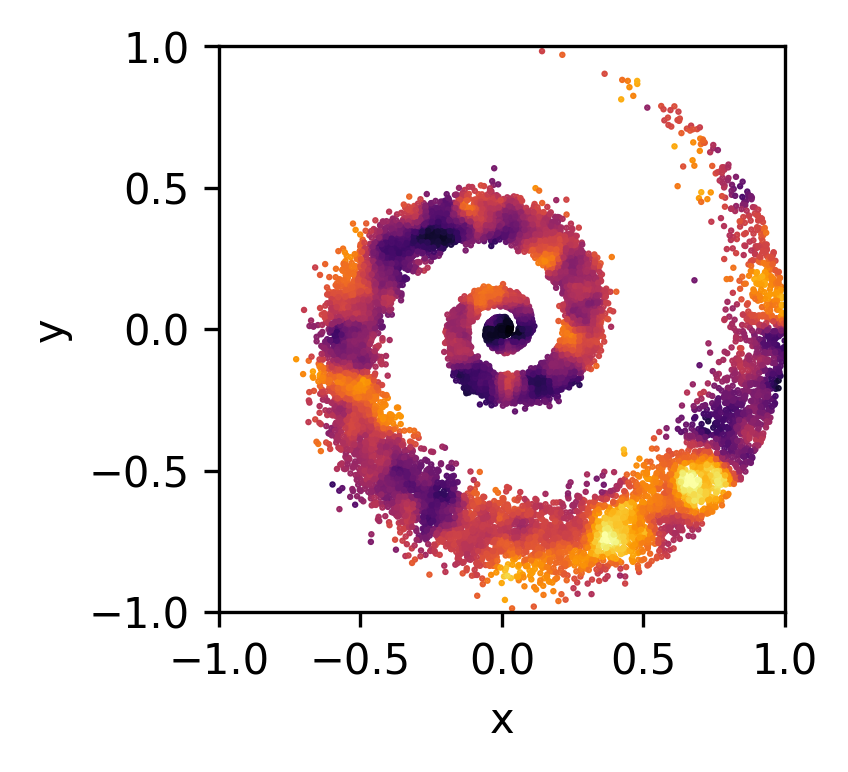

In [57]:
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
s = plt.scatter(*points[:30].T, c=values[:30], cmap='inferno', s=0.3, vmin=-3, vmax=3)
ax.set(aspect='equal', xlim=(-1,1), ylim=(-1,1), xlabel='x', ylabel='y')
# plt.scatter([1.3, 1.6], [1.5, 1.7], c='white', marker='x')

def update(i):
    s.set_offsets(points[:i])
    s.set_array(values[:i].ravel())
    return [s]

ani = FuncAnimation(fig, update, frames=[32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 100000], interval=500, blit=True)
fig.tight_layout()
HTML(ani.to_html5_video())